# Fidelity Prediction of QuCT on Real Quantum Device

**Author:** Congliang Lang & Siwei Tan  

**Date:** 7/4/2024

Based on paper "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features][1]" (MICRO 2023)

[1]: https://dl.acm.org/doi/10.1145/3613424.3614274


In this notebook, we use the fidelity dataset of a custom superconducting quantum devices to evaluate the fidelity prediction model of QuCT. This device is custom with 18 Xmon qubits arranged in a 6×3 grid qubit topology and use RX, RY, RZ, and CZ gates as basis gates, with gate times of 30 ns and 60 ns for single-qubit and two-qubit gates, respectively. The single-qubit gate fidelity, two-qubit fidelity and measurement are 99.97\%, 99.16\% and 94.91\%, repsecitvely, are benchmarked by isolated RB. For simultaneous RB, the single-qubit and two-qubit fidelities of both devices are above 99\% and 98\%, respectively.

<div style="text-align:center;">
    <img src="/HPCA_2025_Tutorial/demo/picture/2_3_processor_topology.jpg"  width="20%" height="20%">
</div>

In [1]:
import os
os.chdir("../..")
import logging
logging.basicConfig(level=logging.WARN)

import numpy as np
import ray
ray.init(log_to_driver=False)

from janusq.objects.backend import  GridBackend
from janusq.analysis.vectorization import RandomwalkModel
from janusq.analysis.fidelity_prediction import FidelityModel
from janusq.baseline.fidelity_prediction.rb_prediction import RBModel
from janusq.tools.ray_func import map

2025-02-08 15:35:49,639	INFO worker.py:1724 -- Started a local Ray instance.


## Load fidelity dataset

In [2]:
from janusq.dataset import real_qc_18bit

circuits = real_qc_18bit
print(len(circuits))

# limit the number of circuits to speedup the model construction
# circuits = circuits[:200]

Traceback (most recent call last):
  File "/Users/chutianyao/Data/Quantum Technology and Device/Tutorial/HPCA 2025/JanusQ/janusq/dataset/__init__.py", line 15, in <module>
    real_qc_5bit = pickle.load(f)
_pickle.UnpicklingError: invalid load key, 'v'.


2500


In [3]:
sub_circuits, sub_fidelities = [], []
for circuit in circuits:
    for sub_cir in circuit.seperatable_circuits:
        sub_circuits.append(sub_cir)
        sub_fidelities.append(sub_cir.ground_truth_fidelity)

print(len(sub_circuits), len(sub_fidelities))

10000 10000


A large amount of zero-valued fidelities means less valid information, which negatively affects the training convergence and the model accuracy. For large-scale quantum device, e.g., 18-qubit device, we use seperable circuits to pervent the final fidelity from vanishing to zero due to a large number of gates. To address this, the separable circuits used in the fidelity dataset restrict the entangled qubits into sub-circuits within a small number of qubits.

<div style="text-align:center;">
    <img src="/HPCA_2025_Tutorial/demo/picture/2_3_large_fidelity.jpg"  width="40%" height="40%">
</div>

In [4]:
# generate train datset and test dataset
from sklearn.model_selection import train_test_split
train_cirucits, test_circuits, train_fidelities, test_fidelities = train_test_split(sub_circuits,  sub_fidelities, test_size=.2)

## Build Vectorization Model

To train the fidelity prediction model, we first build the vectorization model for the quanutm device.

In [5]:
n_qubits = 18
backend = GridBackend(3,6)
up_model = RandomwalkModel(n_steps = 1, n_walks = 20, backend = backend)
up_model.train(circuits, multi_process = True, remove_redundancy = False)

100%|██████████| 5/5 [02:08<00:00, 25.64s/it]


## Train Fidelity Model

In [ ]:
fidelity_model = FidelityModel(up_model)
fidelity_model.train((train_cirucits, train_fidelities), multi_process = True, max_epoch=2000)

6400it [00:00, 1192781.41it/s]
1600it [00:00, 1193258.61it/s]


epoch: 100, 	 epoch loss = 8244.5166015625, 	 validation loss = 9.26734733581543


QuCT can also evaluate the weight of each path to identify high source of error. For example, when two gates leads to high error when they are in the same layer. It may result from crosstalk.

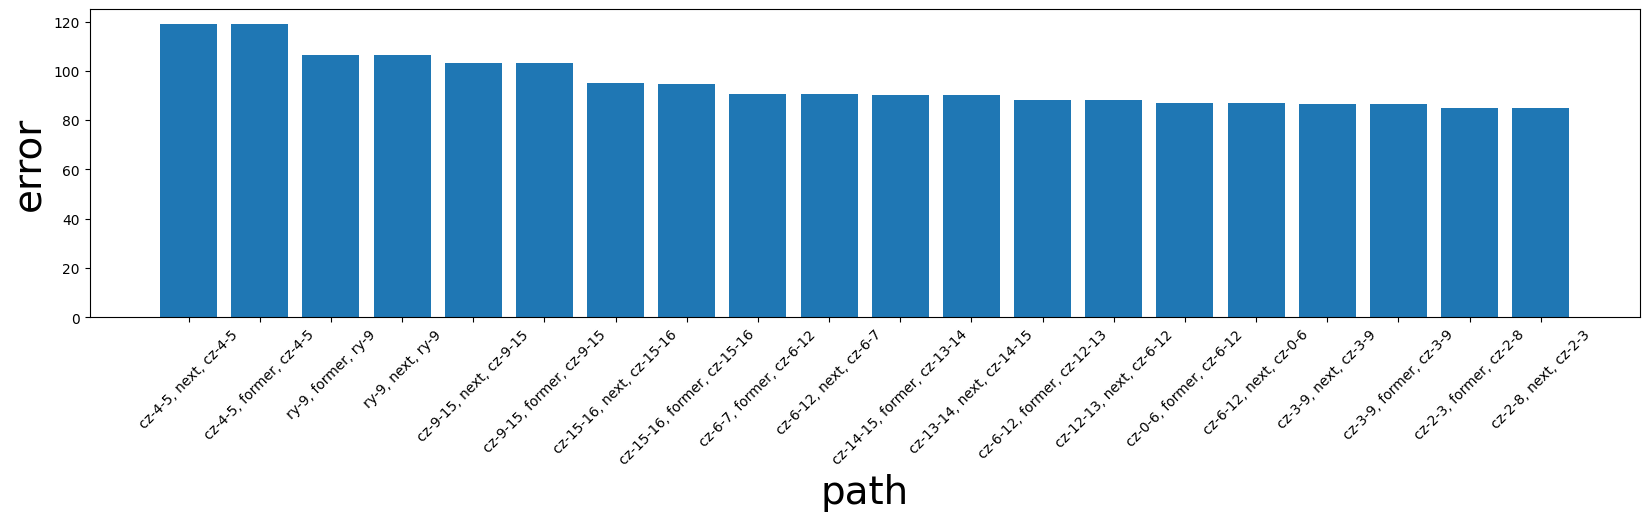

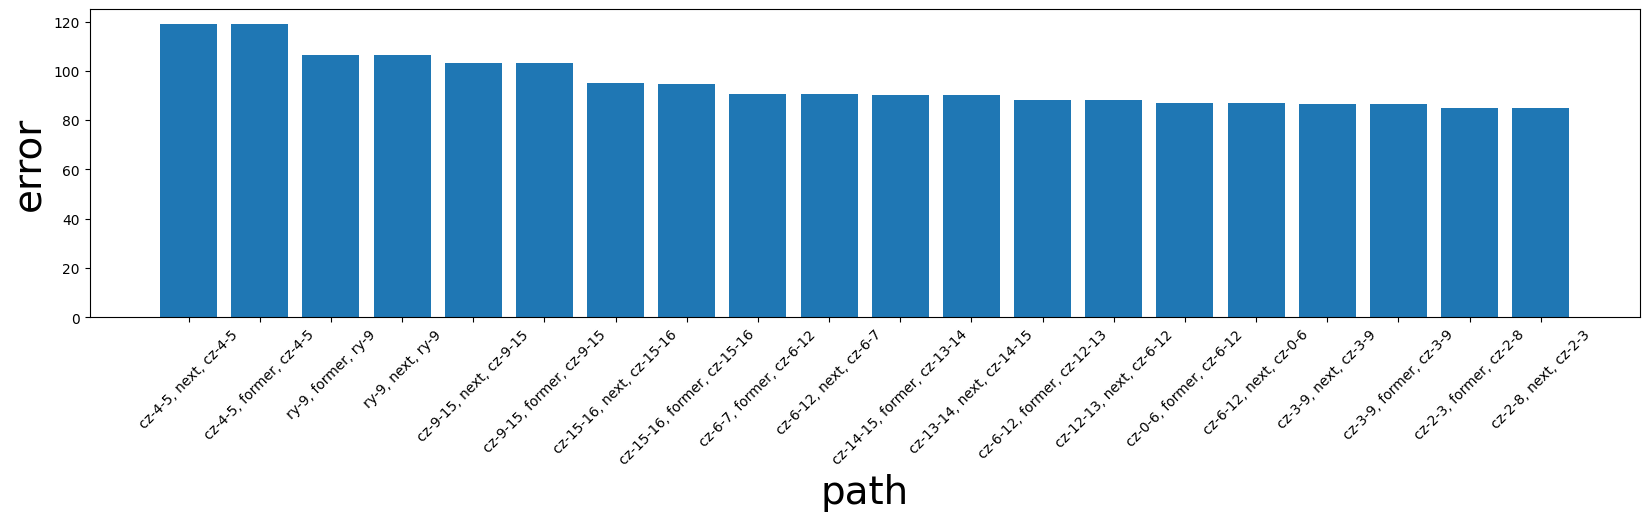

In [ ]:
fidelity_model.plot_path_error()

## Compare to Random Benchmarking

In [ ]:
# load the 1-q fidelities and 2-q fidelities of rb 
fidelity_1q_rb = {0: 0.9994094148043156, 1: 0.9993508083886652, 2: 0.9993513578387458, 3: 0.9996978330672296, 4: 0.9997258463524775, 
                           5: 0.9993898065578337, 6: 0.9998335484697743, 7: 0.9997460044815009,  8: 0.9997219426985601, 9: 0.9992924485427597, 
                           10: 0.9994018918682177, 11: 0.9998410411794697, 12: 0.9994231683912435, 13: 0.9995938422219371, 14: 0.9947661045069707, 
                           15: 0.9997576786354693, 16: 0.9998387638441334,  17: 0.9996691783504945} 
fidelity_2q_rb = {(5,11): 0.993651602350742, (11,17): 0.9943374306798481,  (4,5): 0.9810612795342519,  (10,11): 0.9915544427978213,  
                           (16,17): 0.9908639448675425,  (4,10): 0.9914941121128581,  (10,16): 0.9868303060599511,  (3,4): 0.9899226069903224,  
                           (9,10): 0.9945250360193374,  (15,16): 0.9933864398113101,  (3,9): 0.991508018299962,  (9,15): 0.993773364368622,  
                           (2,3): 0.9802169505904027,  (8,9): 0.9912794178832776,  (14,15): 0.9867247971867894,  (2,8): 0.9765590682588615,  
                           (8,14): 0.9863913339619792,  (1,2): 0.9713229087974011,  (7,8): 0.9908463216114999,  (13,14): 0.9564265490465305,  
                           (1,7): 0.9856880460026779,  (7,13): 0.9935440562158602,  (0,1): 0.9833453296232256,  (6,7): 0.9939901490743566,  
                           (12,13): 0.9821366244436676,  (0,6): 0.9861987068804432,  (6,12): 0.9863008252688662} 


In [ ]:
rb_fidelities = np.array(map(lambda circuit: RBModel.get_rb_fidelity(circuit, fidelity_1q_rb, fidelity_2q_rb), test_circuits))
janusct_fidelities = np.array(map(lambda circuit: fidelity_model.predict_circuit_fidelity(circuit), test_circuits))

0.7201742753242955 0.15705194075458723
0.5370157751765189 0.4582217951424694


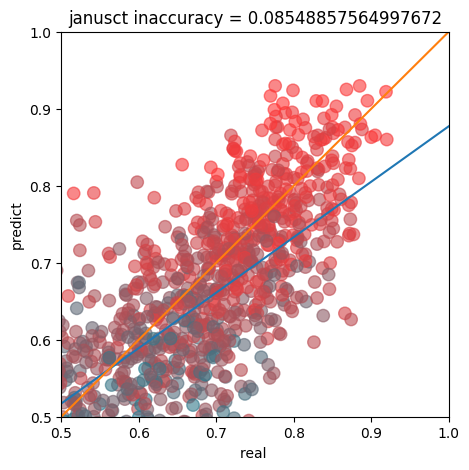

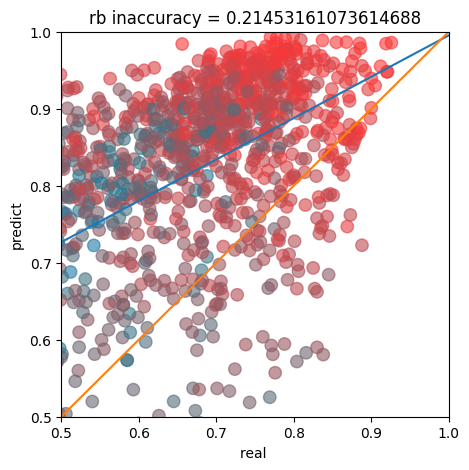

In [ ]:
from janusq.tools.plot import plot_scatter

durations = np.array([cir.duration for cir in test_circuits])

fig_quct, axes_quct = plot_scatter(test_fidelities, janusct_fidelities, durations, title = f"janusct inaccuracy = {np.abs(test_fidelities - janusct_fidelities).mean()}")
fig_rb, axes_rb = plot_scatter(test_fidelities, rb_fidelities, durations, title = f"rb inaccuracy = {np.abs(test_fidelities - rb_fidelities).mean()}")